# Results

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
#original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
#splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

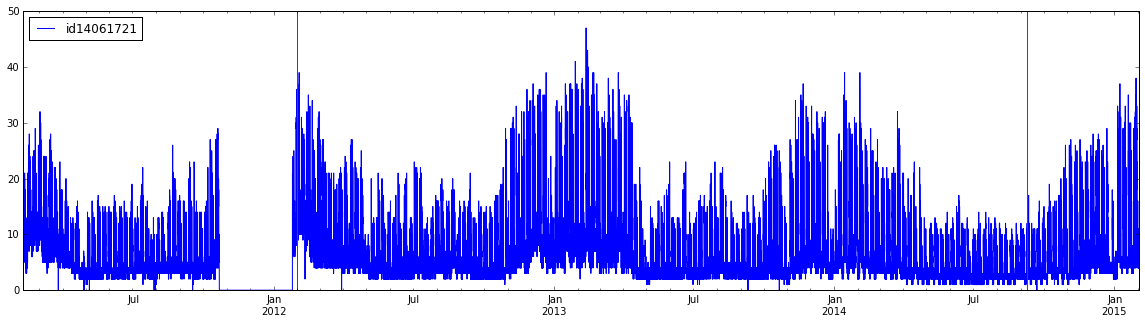

In [4]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [5]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

## Creating Feature Sets

Warning: This feature sets should change when you compute new feature importances!!

In [6]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [7]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Define Models, Feature sets and Error metrics

In [144]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [138]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [#{'name': "Baselines", 'ftrs': ar_ftrs},
             {'name': "AR", 'ftrs': ar_ftrs},
             {'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             {'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             {'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

#Forecasts  

Working with sensor: id14061721

	-->Prediction horizont: 10h. Shifting runtime: 139.47s

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




		-->Dataset: AR, X_train: (91345L, 16L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.728, runtime: 1.97s
			-->Training model: K Nearest Neighbors, score: 0.648, runtime: 4.89s
			-->Training model: Random Forest, score: 0.737, runtime: 16.93s

		-->Dataset: AR_WC_WF, X_train: (91345L, 67L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.731, runtime: 1.95s
			-->Training model: K Nearest Neighbors, score: -0.252, runtime: 5.02s
			-->Training model: Random Forest, score: 0.740, runtime: 105.80s

		-->Dataset: AR_DT, X_train: (91345L, 27L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.776, runtime: 1.98s
			-->Training model: K Nearest Neighbors, score: 0.676, runtime: 12.22s
			-->Training model: Random Forest, score: 0.814, runtime: 24.00s

		-->Dataset: AR_WF_DT, X_train: (91345L, 34L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.778, runtime: 2.01s
			-->Training model: K Nearest Neighbor

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


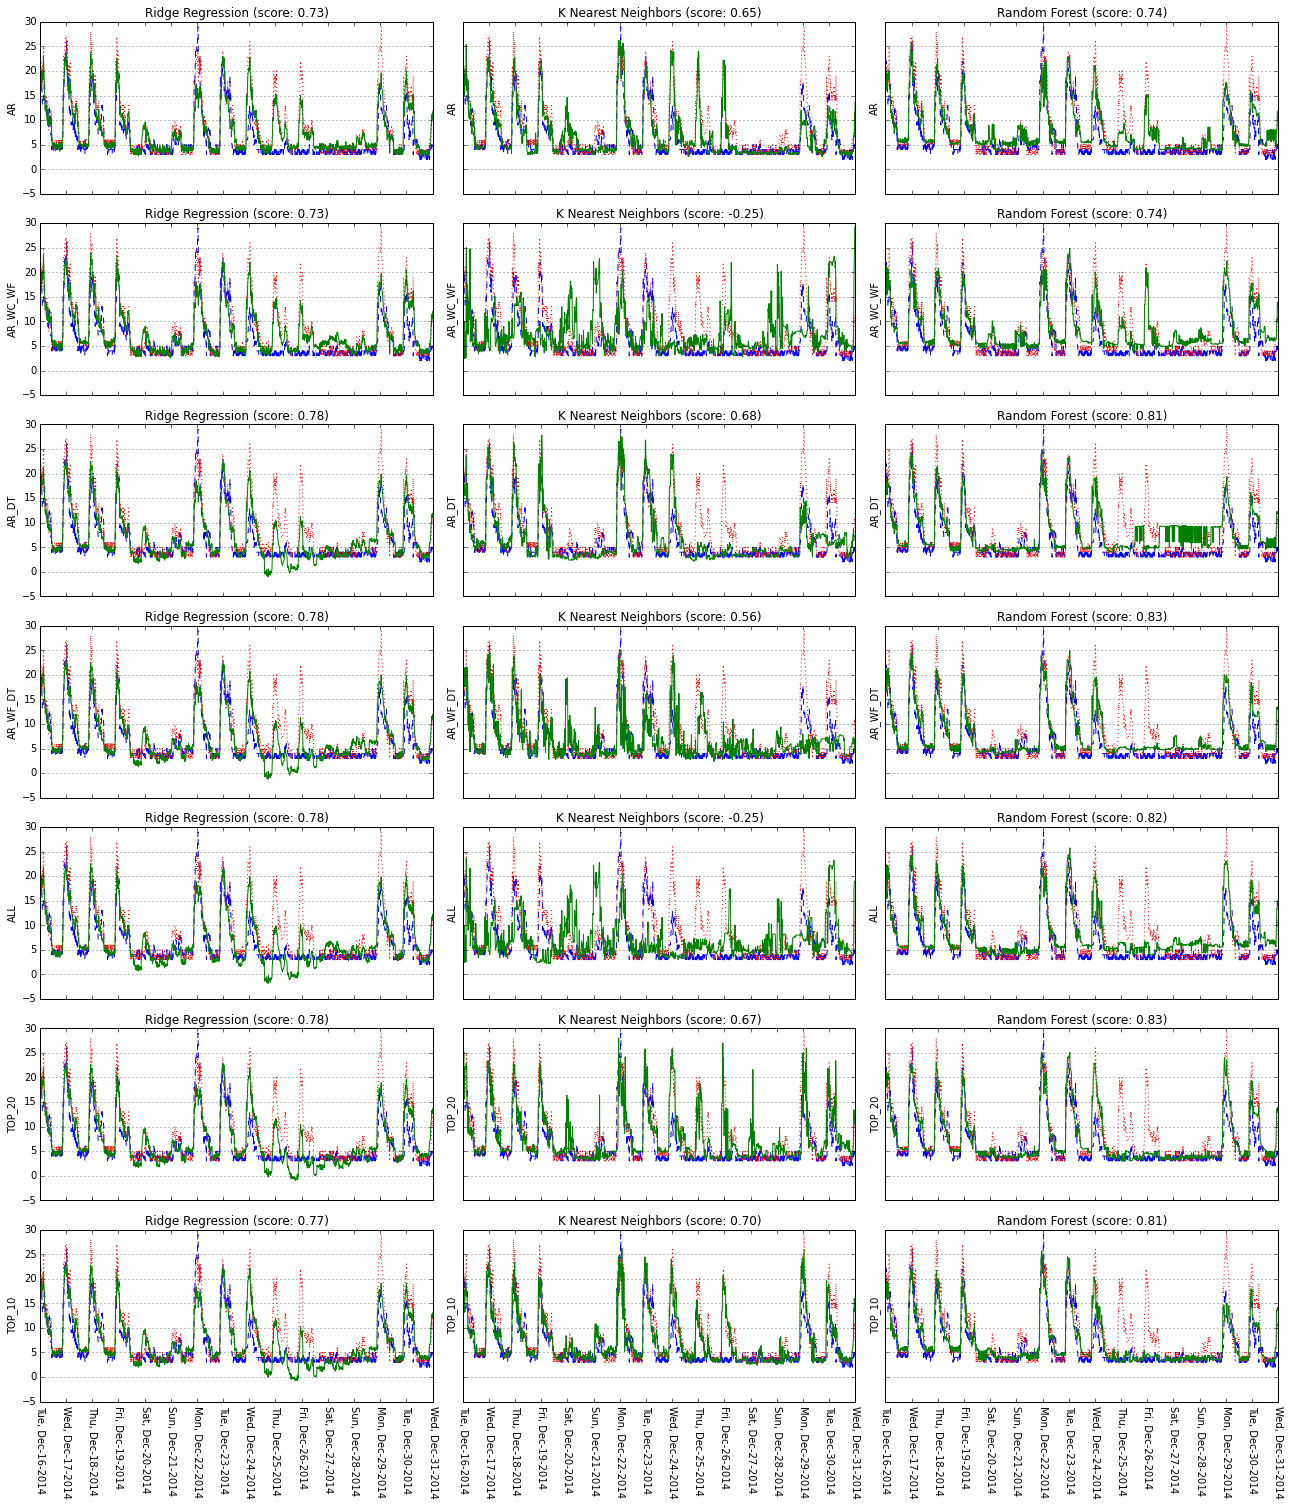

In [140]:
runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
#runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays(models, names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[]], names=['sensor'])) 

def make_prediction_plots(verbose=False):

    #sensor_list = list(data)[:30] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674']
    #sensor_list = ["id11010024", 'id14061721', 'id12041992', "id12041022"]
    sensor_list = ['id14061721']

    for sensor_name in sensor_list:
        
        print "Working with sensor: {}".format(sensor_name)
        
        f, axx = plt.subplots(len(data_sets), len(models), sharey=True, sharex=True)
        #f, axx = plt.subplots(len(data_sets), len(models))
        f.set_size_inches(6*len(models), 3*len(data_sets))
        #plt.suptitle('Learning curve', fontsize=15)
    

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, 
                           inplace=True)

        for horizon in range (10,11):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for idx, data_set in enumerate(data_sets):            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values 
                
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                                                                     
                if verbose: print "\n\t\t-->Dataset: {}, X_train: {}, y_train: {}".format(
                        data_set['name'], X_train.shape, y_train.shape)

                for idy, model in enumerate(models): 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    if model['name'] == "Ridge Regression":
                        # Train model with dummy features
                        mdl.fit(X_train_dummy, y_train_dummy)
                        # Compute models score (R2)
                        score = mdl.score(X_test_dummy, y_test_dummy)
                        testing_data['Prediction'] = mdl.predict(X_test_dummy)
                    else:
                        mdl.fit(X_train,y_train)
                        # Compute models score (R2)
                        score = mdl.score(X_test, y_test)
                        testing_data['Prediction'] = mdl.predict(X_test)
                    runtime = time.time() - start # Calculate runtimea
                    
                    # TODO: save runtime to dataframe!!!
                    runtimes_df.loc[(horizon, data_set['name'], model['name']), (sensor_name)] = runtime
                    



                    #ax = testing_data['2014-10-22 14:00:00':'2014-11-04 14:00:00'][['shifted_measurement', 'shifted_measurement_1w', 'Prediction']].plot(
                    data_to_plot = testing_data['2014-12-16 00:00:00':'2014-12-31 00:00:00'][['shifted_measurement', 'shifted_measurement_1w', 'Prediction']]
                    
                    xticks = pd.date_range(start=data_to_plot.index[0], end=data_to_plot.index[-1], freq='D')
                    
                    ax = data_to_plot.plot(ax = axx[idx,idy], title = (model['name'] + " (score: %0.2f)" % score), 
                                           style=['b--','r:','g-'], legend=False, xticks=xticks.to_pydatetime())
                    
                    #ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in data_to_plot.index.to_pydatetime()]);
                    #ax.set_xticklabels([x.strftime('%a (%d. %b)') for x in xticks], rotation=-90);
                    ax.set_xticklabels([x.strftime('%a, %b-%d-%Y') for x in xticks], rotation=-90);
                    ax.set_xticklabels([], minor=True)
                    
                    ax.set_ylabel(data_set['name'])
                    #ax.set_xlabel(data_set['name'])
                    ax.yaxis.grid(True)
        
                    # Printing results to console
                    if verbose: print "\t\t\t-->Training model: {}, score: {:.3f}, runtime: {:.2f}s".format(
                            model['name'], score, runtime)
    
        plt.tight_layout()
        #plt.figure()
        plt.show()

make_prediction_plots(verbose=True)

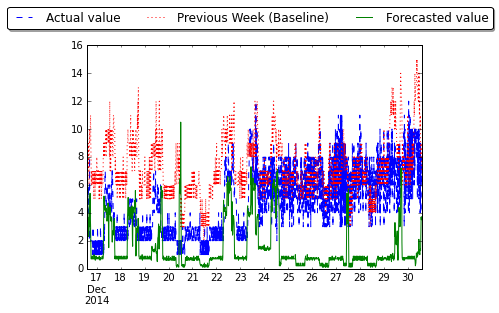

In [129]:
test = data['2014-12-16 14:00:00':'2014-12-30 14:00:00'][['id14061680','id14061714','id11010024']].plot(style=['b--','r:','g-'])
test.legend(['Actual value','Previous Week (Baseline)','Forecasted value'], 
            fancybox=True, shadow=True, ncol=3, bbox_to_anchor=(1.23, 1.2))

In [55]:
test.index[0]

Timestamp('2014-12-16 14:00:00')

In [66]:
xticks = pd.date_range(start='2014-12-16 18:00:00', end=test.index[-1], freq='2D')

In [67]:
xticks

DatetimeIndex(['2014-12-16 18:00:00', '2014-12-18 18:00:00',
               '2014-12-20 18:00:00', '2014-12-22 18:00:00',
               '2014-12-24 18:00:00', '2014-12-26 18:00:00',
               '2014-12-28 18:00:00', '2014-12-30 18:00:00'],
              dtype='datetime64[ns]', freq='2D', tz=None)

In [ ]:
xticks = pandas.date_range(start=dStart, end=dEnd, freq='W-Tue')

In [96]:
[x.strftime('%a, (%m.%d.)') for x in xticks]

['Tue, (12.16.)',
 'Thu, (12.18.)',
 'Sat, (12.20.)',
 'Mon, (12.22.)',
 'Wed, (12.24.)',
 'Fri, (12.26.)',
 'Sun, (12.28.)',
 'Tue, (12.30.)']

#Runtimes 

In [164]:
runtimes_df

sensor                                id14061721
horizon dataset  model                          
10      ALL      Ridge Regression          0.796
                 K Nearest Neighbors       6.838
                 Random Forest            70.001
        AR_WC_WF Ridge Regression          0.720
                 K Nearest Neighbors       5.320
                 Random Forest            66.450
        AR_WC_DT Ridge Regression          0.799
                 K Nearest Neighbors       5.302
                 Random Forest            61.992
        AR_WF_DT Ridge Regression          0.779
                 K Nearest Neighbors      16.964
                 Random Forest            18.830
        AR_DT    Ridge Regression          0.809
                 K Nearest Neighbors      16.897
                 Random Forest            13.070
        AR       Ridge Regression          0.714
                 K Nearest Neighbors       7.637
                 Random Forest            11.296
        TOP_20   Ridge Regression          0.714
                 K Nearest Neighbors       3.901
                 Random Forest            17.724
        TOP_10   Ridge Regression          0.714
                 K Nearest Neighbors       1.901
                 Random Forest             7.236
        SELECTED Ridge Regression          0.701
                 K Nearest Neighbors       3.822
                 Random Forest             8.865

# Error Histogram 

In [60]:
baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          #{'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [#{'name': "Baselines", 'ftrs': ar_ftrs},
             #{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             {'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             #{'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [61]:
test_df = pd.DataFrame()

Working with sensor: id12041022

	-->Prediction horizont: 10h. Shifting runtime: 36.77s

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




		-->Dataset: AR_DT, X_train: (91345L, 27L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.836, runtime: 1.03s

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



			-->Training model: Random Forest, score: 0.908, runtime: 29.78s

		-->Dataset: AR_WF_DT, X_train: (91345L, 34L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.838, runtime: 1.03s
			-->Training model: Random Forest, score: 0.908, runtime: 34.75s


C:\Python27\lib\site-packages\IPython\kernel\__main__.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


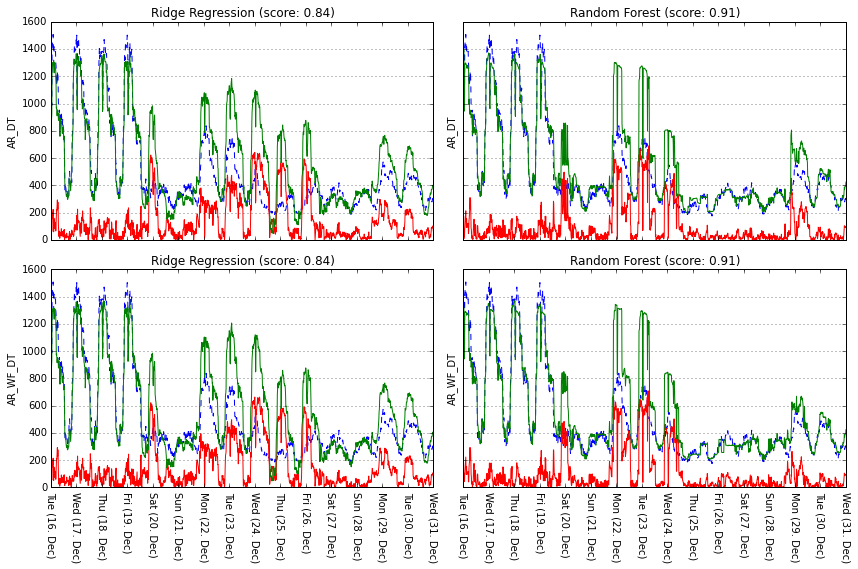

In [72]:
runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
#runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays(models, names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[]], names=['sensor'])) 

def make_prediction_plots(verbose=False):

    #sensor_list = list(data)[:30] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674']
    #sensor_list = ["id11010024", 'id14061721', 'id12041992', "id12041022"]
    sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        
        print "Working with sensor: {}".format(sensor_name)
        
        f, axx = plt.subplots(len(data_sets), len(models), sharey=True, sharex=True)
        #f, axx = plt.subplots(len(data_sets), len(models))
        f.set_size_inches(6*len(models), 4*len(data_sets))
        #plt.suptitle('Learning curve', fontsize=15)
    

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, 
                           inplace=True)

        for horizon in range (10,11):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for idx, data_set in enumerate(data_sets):            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values 
                
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                                                                     
                if verbose: print "\n\t\t-->Dataset: {}, X_train: {}, y_train: {}".format(
                        data_set['name'], X_train.shape, y_train.shape)

                for idy, model in enumerate(models): 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    if model['name'] == "Ridge Regression":
                        # Train model with dummy features
                        mdl.fit(X_train_dummy, y_train_dummy)
                        # Compute models score (R2)
                        score = mdl.score(X_test_dummy, y_test_dummy)
                        testing_data['Prediction'] = mdl.predict(X_test_dummy)
                        testing_data['absolute_error'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                    else:
                        mdl.fit(X_train,y_train)
                        # Compute models score (R2)
                        score = mdl.score(X_test, y_test)
                        testing_data['Prediction'] = mdl.predict(X_test)
                        testing_data['absolute_error'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                        test_df['Actual value'] = testing_data['shifted_measurement']
                        test_df['Previous week'] = testing_data['shifted_measurement_1w']
                        test_df['Predicted value'] = testing_data['Prediction']
                        test_df['Predicted error value'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                        test_df['Baseline error value'] = abs(testing_data['shifted_measurement_1w'] - testing_data['shifted_measurement'])
                    runtime = time.time() - start # Calculate runtimea
                    
                    # TODO: save runtime to dataframe!!!
                    runtimes_df.loc[(horizon, data_set['name'], model['name']), (sensor_name)] = runtime
                    



                    #ax = testing_data['2014-10-22 14:00:00':'2014-11-04 14:00:00'][['shifted_measurement', 'shifted_measurement_1w', 'Prediction']].plot(
                    data_to_plot = testing_data['2014-12-16 00:00:00':'2014-12-31 00:00:00'][['shifted_measurement', 'absolute_error', 'Prediction']]
                    
                    xticks = pd.date_range(start=data_to_plot.index[0], end=data_to_plot.index[-1], freq='D')
                    
                    ax = data_to_plot.plot(ax = axx[idx,idy], title = (model['name'] + " (score: %0.2f)" % score), 
                                           style=['b--','r-','g-'], legend=False, xticks=xticks.to_pydatetime())
                    
                    #ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in data_to_plot.index.to_pydatetime()]);
                    ax.set_xticklabels([x.strftime('%a (%d. %b)') for x in xticks], rotation=-90);
                    ax.set_xticklabels([], minor=True)
                    
                    ax.set_ylabel(data_set['name'])
                    #ax.set_xlabel(data_set['name'])
                    ax.yaxis.grid(True)
        
                    # Printing results to console
                    if verbose: print "\t\t\t-->Training model: {}, score: {:.3f}, runtime: {:.2f}s".format(
                            model['name'], score, runtime)
    
        plt.tight_layout()
        #plt.figure()
        plt.show()

make_prediction_plots(verbose=True)

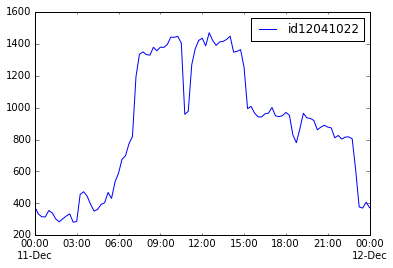

In [11]:
original_data['2014-12-11 00:00:00':'2014-12-12 00:00:00'][["id12041022"]].plot()

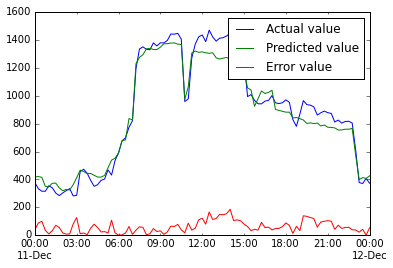

In [12]:
test_df.shift(10, freq='H')['2014-12-11 00:00:00':'2014-12-12 00:00:00'].plot()

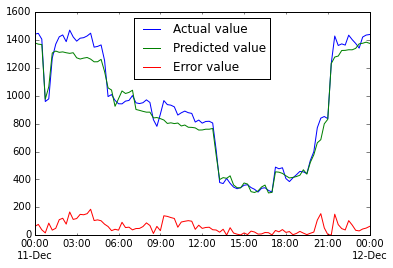

In [13]:
test_df['2014-12-11 00:00:00':'2014-12-12 00:00:00'].plot()

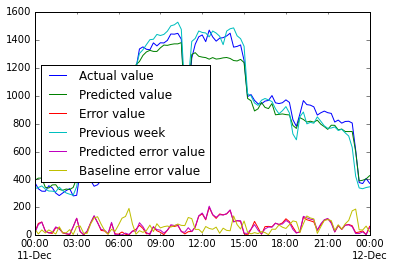

In [73]:
test_df_fixed = test_df.shift(10, freq='H')
test_df_fixed['2014-12-11 00:00:00':'2014-12-12 00:00:00'].plot()

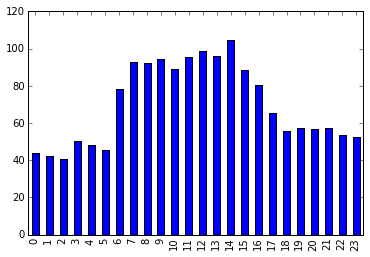

In [74]:
test_df_fixed.groupby(test_df_fixed.index.hour)['Error value'].mean().plot(kind='bar')

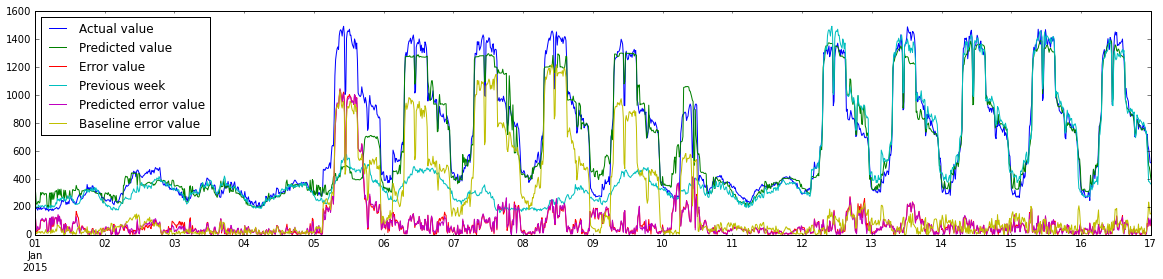

In [75]:
test_df_fixed['2015-1-1 00:00:00':'2015-1-17 00:00:00'].plot(figsize=(20,4))

### Mean Load 

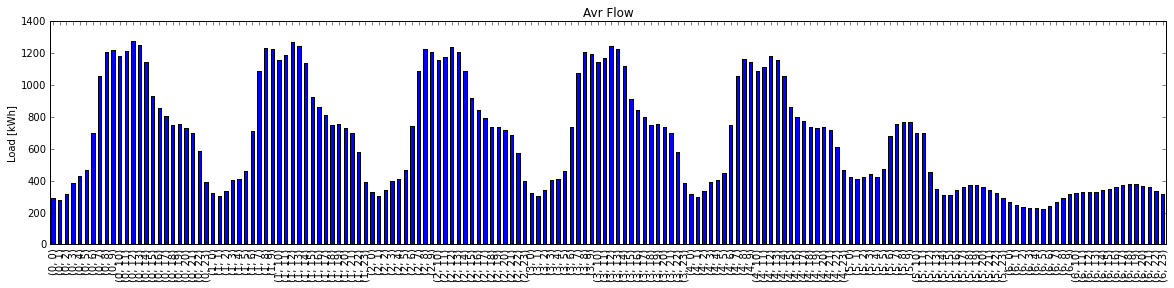

In [185]:
ax = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Actual value'].mean().plot(
    kind='bar', figsize=(20,4), title="Avr Flow")

ax.set_ylabel('Load [kWh]')

### Std Load

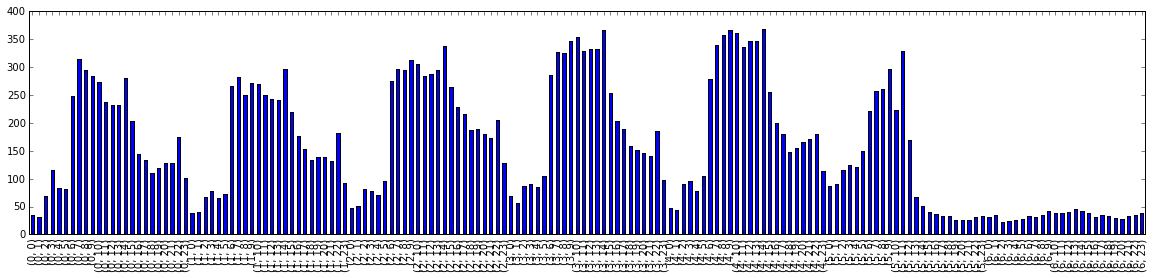

In [52]:
test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Actual value'].std().plot(
    kind='bar', figsize=(20,4))

### Mean Error for 10h into the future

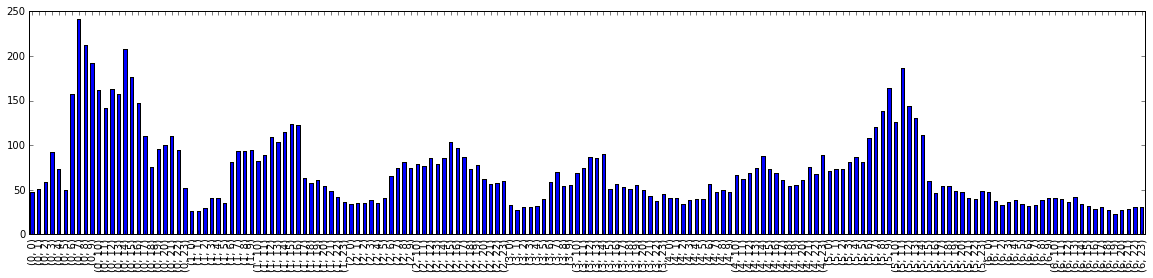

In [77]:
test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Predicted error value'].mean().plot(
    kind='bar', figsize=(20,4))

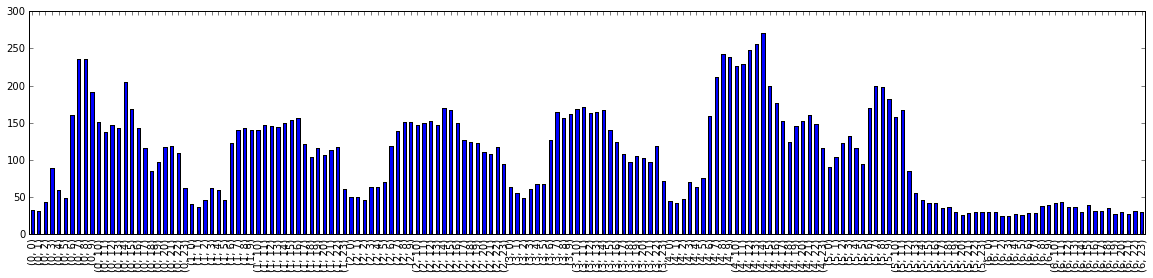

In [76]:
test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Baseline error value'].mean().plot(
    kind='bar', figsize=(20,4))

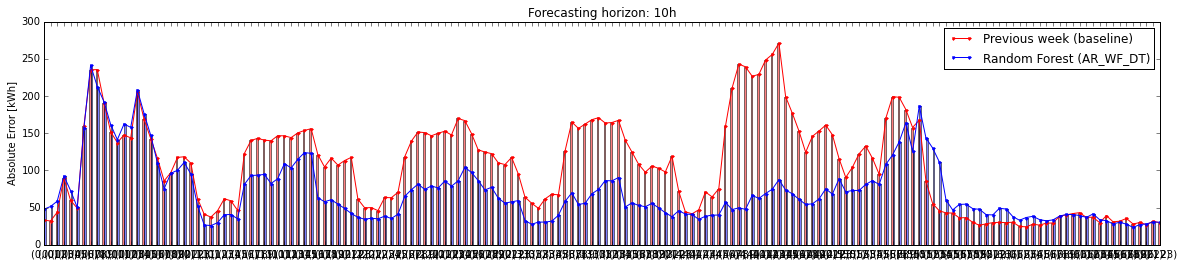

In [183]:
ax = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    kind='bar', figsize=(20,4), color=['r','b'], alpha=0.5)
test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    ax=ax, figsize=(20,4), style=['r.-','b.-'])

ax.legend(["Previous week (baseline)", "Random Forest (AR_WF_DT)"])
ax.set_ylabel('Absolute Error [kWh]')
#ax.set_title("Mean errors for main distribution transformer (id12041022)")
ax.set_title("Forecasting horizon: 10h")

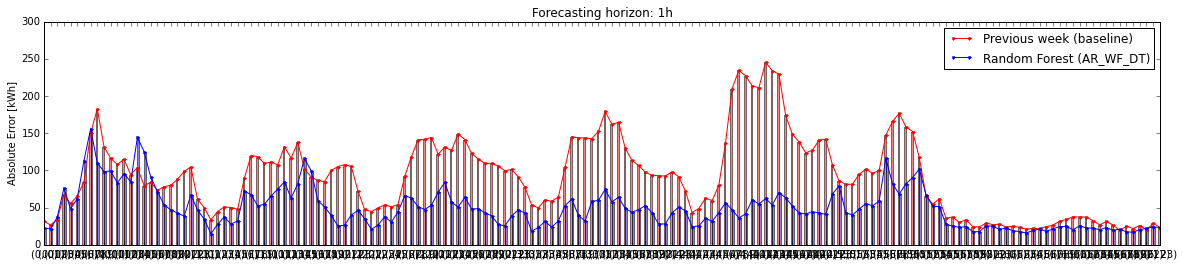

In [184]:
ax = test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    kind='bar', figsize=(20,4), color=['r','b'], alpha=0.5, ylim=(0,300))
test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    ax=ax, figsize=(20,4), style=['r.-','b.-'])

ax.legend(["Previous week (baseline)", "Random Forest (AR_WF_DT)"])
ax.set_ylabel('Absolute Error [kWh]')
ax.set_title("Forecasting horizon: 1h")
#ax.yaxis.grid(True)

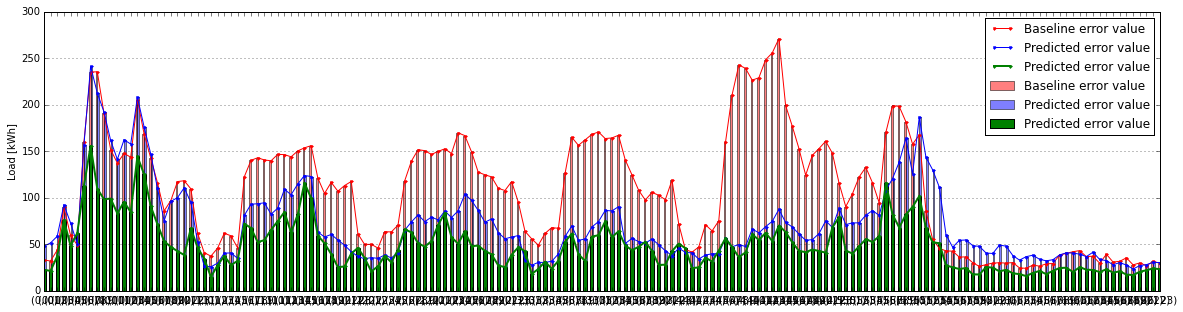

In [165]:
ax = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    kind='bar', figsize=(20,5), color=['r','b'], alpha=0.5)
test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Baseline error value','Predicted error value'].mean().plot(
    ax=ax, figsize=(20,5), style=['r.-','b.-'])
test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Predicted error value'].mean().plot(
    ax=ax, kind='bar', figsize=(20,5), color=['g'], legend=True)
test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Predicted error value'].mean().plot(
    ax=ax, figsize=(20,5), style=['g.-'], linewidth=2, legend=True)

ax.legend()
ax.set_ylabel('Load [kWh]')
ax.yaxis.grid(True)

Monadys are very bad. Maybe because the data are comming from Sunday which is very different/

### Mean Error for 1h into the future

In [122]:
test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Error value'].mean().plot(
    kind='bar', figsize=(20,4))

KeyError: 'Column not found: Error value'

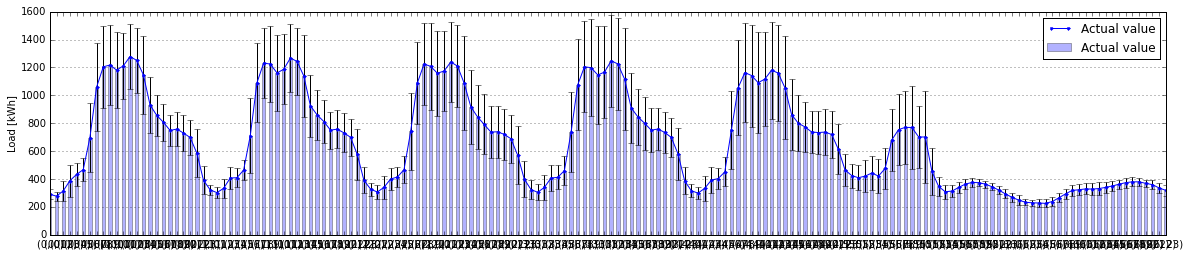

In [162]:
err = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Actual value'].std()

ax = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Actual value'].mean().plot(
    kind='bar', figsize=(20,4), yerr=err, alpha=0.3)

test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Actual value'].mean().plot(
    ax=ax, figsize=(20,4), style=['b.-'])

ax.yaxis.grid(True)
ax.legend()
ax.set_ylabel('Load [kWh]')

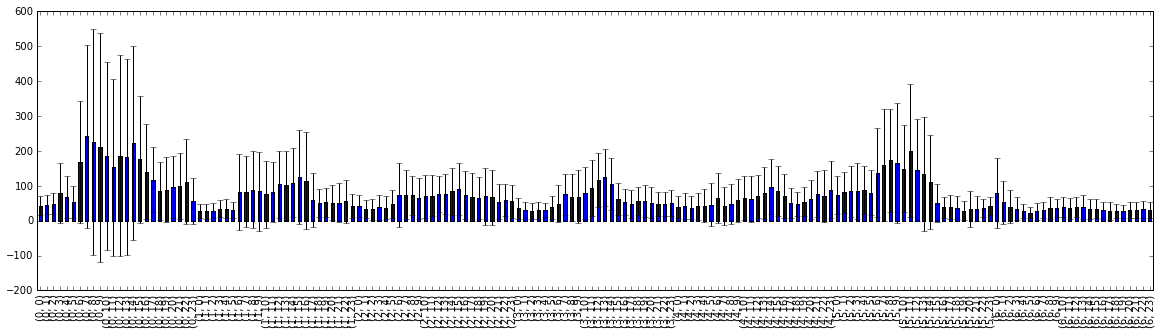

In [33]:
err = test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Error value'].std()

test_df_fixed.groupby([test_df_fixed.index.dayofweek, test_df_fixed.index.hour])['Error value'].mean().plot(
    kind='bar', figsize=(20,5), yerr=err)

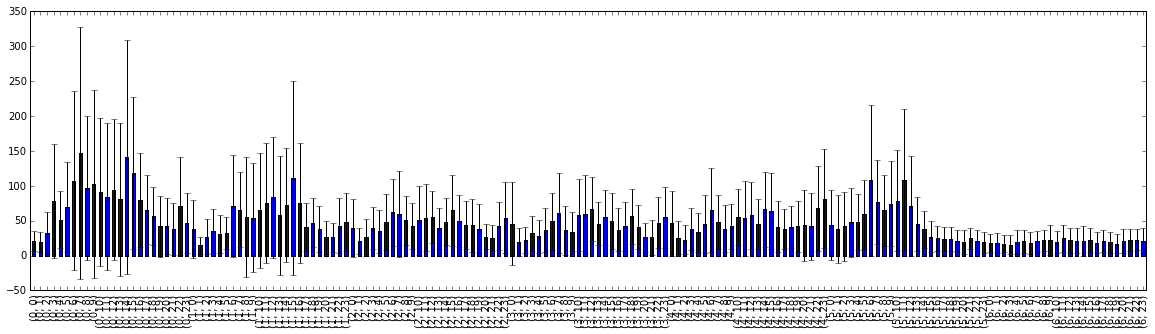

In [47]:
err = test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Error value'].std()

test_df_1h_fixed.groupby([test_df_1h_fixed.index.dayofweek, test_df_1h_fixed.index.hour])['Error value'].mean().plot(
    kind='bar', figsize=(20,5), yerr=err)

In [183]:
#test_df.groupby([test_df.index.dayofweek, test_df.index.hour])['Error value'].mean()
test_df.groupby(test_df.index.hour)['Error value'].mean()

0      94.380610
1      98.696466
2     104.134912
3     101.507730
4     105.060909
5      87.465503
6      73.427878
7      58.548775
8      52.851171
9      54.154384
10     55.775330
11     56.742836
12     59.079669
13     53.255431
14     47.386367
15     43.444170
16     42.569522
17     48.889261
18     46.879148
19     45.996426
20     85.248622
21     99.391233
22     99.326500
23     97.154993
Name: Error value, dtype: float64

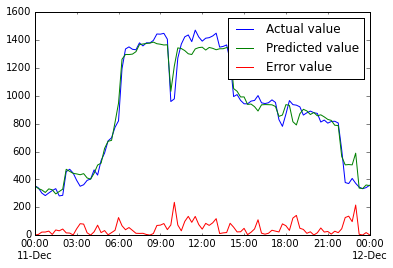

In [43]:
test_df_1h['2014-12-11 00:00:00':'2014-12-12 00:00:00'].plot()

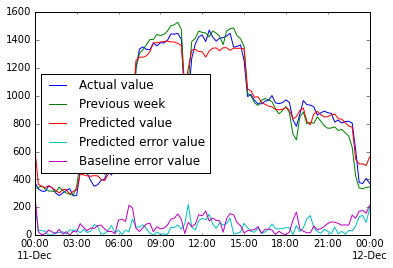

In [102]:
test_df_1h_fixed['2014-12-11 00:00:00':'2014-12-12 00:00:00'].plot()

In [98]:
test_df_1h = pd.DataFrame()

Working with sensor: id12041022

	-->Prediction horizont: 1h. Shifting runtime: 73.74s

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




		-->Dataset: AR_DT, X_train: (91345L, 27L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.916, runtime: 2.06s

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



			-->Training model: Random Forest, score: 0.959, runtime: 26.80s

		-->Dataset: AR_WF_DT, X_train: (91345L, 34L), y_train: (91345L,)
			-->Training model: Ridge Regression, score: 0.916, runtime: 2.18s
			-->Training model: Random Forest, score: 0.959, runtime: 32.26s


C:\Python27\lib\site-packages\IPython\kernel\__main__.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


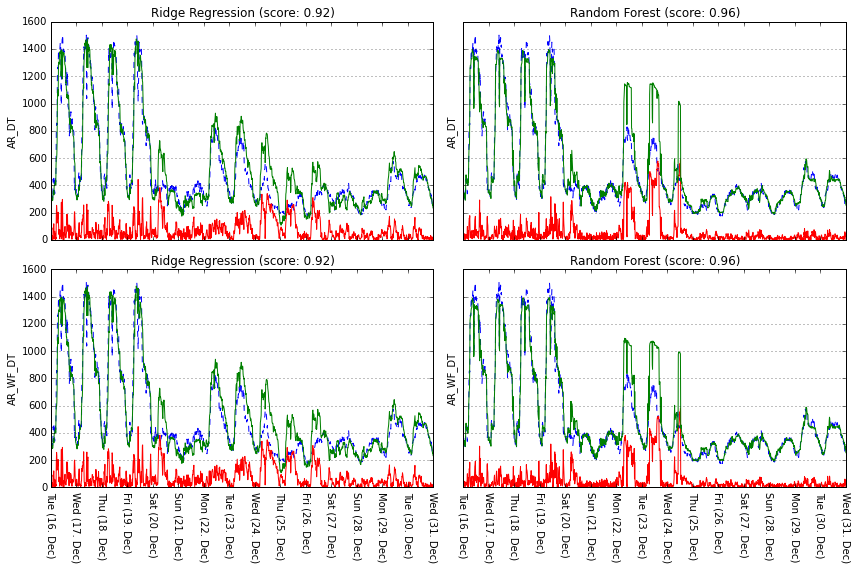

In [100]:
runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
#runtimes_df = pd.DataFrame(index=pd.MultiIndex.from_arrays(models, names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[]], names=['sensor'])) 

def make_prediction_plots(verbose=False):

    #sensor_list = list(data)[:30] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674']
    #sensor_list = ["id11010024", 'id14061721', 'id12041992', "id12041022"]
    sensor_list = ['id12041022']

    for sensor_name in sensor_list:
        
        print "Working with sensor: {}".format(sensor_name)
        
        f, axx = plt.subplots(len(data_sets), len(models), sharey=True, sharex=True)
        #f, axx = plt.subplots(len(data_sets), len(models))
        f.set_size_inches(6*len(models), 4*len(data_sets))
        #plt.suptitle('Learning curve', fontsize=15)
    

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, 
                           inplace=True)

        for horizon in range (1,2):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for idx, data_set in enumerate(data_sets):            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values 
                
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                                                                     
                if verbose: print "\n\t\t-->Dataset: {}, X_train: {}, y_train: {}".format(
                        data_set['name'], X_train.shape, y_train.shape)

                for idy, model in enumerate(models): 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    if model['name'] == "Ridge Regression":
                        # Train model with dummy features
                        mdl.fit(X_train_dummy, y_train_dummy)
                        # Compute models score (R2)
                        score = mdl.score(X_test_dummy, y_test_dummy)
                        testing_data['Prediction'] = mdl.predict(X_test_dummy)
                        testing_data['absolute_error'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                    else:
                        mdl.fit(X_train,y_train)
                        # Compute models score (R2)
                        score = mdl.score(X_test, y_test)
                        testing_data['Prediction'] = mdl.predict(X_test)
                        testing_data['absolute_error'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                        test_df_1h['Actual value'] = testing_data['shifted_measurement']
                        test_df_1h['Previous week'] = testing_data['shifted_measurement_1w']
                        test_df_1h['Predicted value'] = testing_data['Prediction']
                        test_df_1h['Predicted error value'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement'])
                        test_df_1h['Baseline error value'] = abs(testing_data['Prediction'] - testing_data['shifted_measurement_1w'])
                    runtime = time.time() - start # Calculate runtimea
                    
                    # TODO: save runtime to dataframe!!!
                    runtimes_df.loc[(horizon, data_set['name'], model['name']), (sensor_name)] = runtime
                    



                    #ax = testing_data['2014-10-22 14:00:00':'2014-11-04 14:00:00'][['shifted_measurement', 'shifted_measurement_1w', 'Prediction']].plot(
                    data_to_plot = testing_data['2014-12-16 00:00:00':'2014-12-31 00:00:00'][['shifted_measurement', 'absolute_error', 'Prediction']]
                    
                    xticks = pd.date_range(start=data_to_plot.index[0], end=data_to_plot.index[-1], freq='D')
                    
                    ax = data_to_plot.plot(ax = axx[idx,idy], title = (model['name'] + " (score: %0.2f)" % score), 
                                           style=['b--','r-','g-'], legend=False, xticks=xticks.to_pydatetime())
                    
                    #ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in data_to_plot.index.to_pydatetime()]);
                    ax.set_xticklabels([x.strftime('%a (%d. %b)') for x in xticks], rotation=-90);
                    ax.set_xticklabels([], minor=True)
                    
                    ax.set_ylabel(data_set['name'])
                    #ax.set_xlabel(data_set['name'])
                    ax.yaxis.grid(True)
        
                    # Printing results to console
                    if verbose: print "\t\t\t-->Training model: {}, score: {:.3f}, runtime: {:.2f}s".format(
                            model['name'], score, runtime)
    
        plt.tight_layout()
        #plt.figure()
        plt.show()

make_prediction_plots(verbose=True)

In [101]:
test_df_1h_fixed = test_df_1h.shift(1, freq='H')